In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm, PowerNorm, BoundaryNorm
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import interp1d

import sys
sys.path.append('src')
from Like import Floor_2D
%matplotlib inline


# Plotting functions

In [2]:
def extrapolate(data, mass=1e6):
    m0, s0 = data[-1]
    return np.concatenate([data,[[mass, s0*mass/m0]]], axis=0)

def plotdata(ax, filename=None, label=None, filtsigma=0, data=None, extrapmass=None, loadkwargs=dict(), **kwargs):
    if data is None:
        data = np.loadtxt(filename, **loadkwargs)
    if extrapmass is not None:
        data = extrapolate(data, extrapmass)
    if filtsigma:
        y = data[:,1]
        data[:,1] = gaussian_filter1d(y, sigma=filtsigma)
    scalex = kwargs.get('scalex', None)
    if scalex is not None:
        data[:,0] *= scalex
    kwargs.setdefault('linewidth',3)
    if isinstance(label, str):
        kwargs['label'] = label
        label = None
    lines = ax.plot(*(data.T), **kwargs)
    if label is not None:
        label.setdefault('color', lines[0].get_color())
        label.setdefault('alpha', lines[0].properties()['alpha'])
        label.setdefault('x', 1000)
        label.setdefault('y', np.interp(label['x'], data[:,0], data[:,1])*label.pop('yrel',1.25))
        label.setdefault('size',18)
        label.setdefault('rotation', 22 if label['x'] > 99 else 0)
        ax.text(**label)
    return lines

def makecanvas(xlim=(1e0, 0.999e4), ylim=(1e-49, 1e-41), y2=False, nplots=1, **kwargs):
    plt.rcParams['axes.linewidth'] = kwargs.get('linewidth',2)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=kwargs.get('fontsize',25))
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'

    fig, axs = plt.subplots(nplots, 1, figsize=kwargs.get('figsize',(16,15)))
    
    ax = axs if nplots == 1 else axs[0]
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    
    ax.loglog()
    kwargs.setdefault('labelfontsize',25)
    ax.set_xlabel(kwargs.get('xlabel',"Dark matter mass [GeV/c$^{2}$]"), fontsize=kwargs['labelfontsize'])
    ax.set_ylabel(kwargs.get('ylabel',"SI dark matter-nucleon cross section [cm$^{2}$]"),fontsize=kwargs['labelfontsize'])
    
    if y2:
        yax2 = ax.secondary_yaxis('right', functions=(lambda y: y*1e36, lambda y: y*1e-36))
        yax2.set_ylabel('[pb]', fontsize=kwargs['labelfontsize'])
    
    ax.tick_params(which='major',direction='in',width=1,length=15,right=True,top=True,pad=7)
    ax.tick_params(axis='x', which='minor',direction='in',width=1,length=8,right=True,top=True)
    
    for ax in (ax,) if nplots == 1 else axs:
        ax.plotdata = partial(plotdata, ax)
        ax.plotprojection = partial(plotdata, ax, linestyle='dashed')
    return fig, axs

def minbound(curves, masses=None):
    if masses is None:
        masses = np.logspace(-1, 4, 200)
    result = np.array([np.nan]*len(masses))
    for curve in curves:
        if curve[-1][0] < masses[-1]:
            curve = extrapolate(curve, masses[-1])
        yinterp = 10**(interp1d(*(np.log10(curve).T), bounds_error=False)(np.log10(masses)))
        #yinterp = interp1d(*(curve.T), bounds_error=False)(masses)
        result = np.nanmin([result, yinterp], axis=0)
    return np.array([masses, result]).T

def plotnufog(fig, ax, target, spin='SI', vmin=1.5, vmax=3, n_div=0.5, zorder=-100, alpha=1):
    interval = np.linspace(0.0,0.8)
    colors = cm.Blues(interval)
    cmap = LinearSegmentedColormap.from_list('name', colors)
    data = np.loadtxt(f'data/WIMPlimits/mylimits/DLNuFloor{target}_detailed_{spin}.txt')
    Ex = np.flipud(data[1:,1:])
    floor_idx = 1.5
    m,sig,NUFLOOR,DY = Floor_2D(data,Ex_crit=1e19,slope_idx=floor_idx, filt=False)
    DY_cut = np.copy(DY)
    # project the maximum downward
    for j in range(0,len(m)):
        for i in reversed(range(0, len(sig))): #reversed(range(0, len(sig)-1)):
            #DY_cut[i,j] = max(DY_cut[i,j], DY_cut[i+1,j])
            DY_cut[i, j] = np.nanmax(DY_cut[i:i+2,j])
            
    lvl_min = vmin
    lvl_max = 15
            
    DY_cut = gaussian_filter(DY_cut, 1.5)
    DY_cut[DY_cut>lvl_max] = lvl_max
    
    n_lvl = int((lvl_max-lvl_min)/n_div)+1
    levels = np.linspace(lvl_min,lvl_max,n_lvl)
    n_tick = int((vmax-vmin)/n_div)+1
    ticks = np.linspace(vmin,vmax,n_tick)
    cnt = ax.contourf(m,sig,DY_cut,levels=levels,vmin=vmin,vmax=vmax,cmap=cmap,zorder=zorder, alpha=alpha)
    for c in cnt.collections: 
        c.set_edgecolor("face")
        
    im = ax.pcolormesh(-m,sig,DY,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
    fig.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.1, 0.82, 0.82, 0.02])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal',extend='both',extendfrac=0.03,boundar)
    norm = BoundaryNorm(ticks, cmap.N, extend='both')
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax,orientation='horizontal',extend='both',extendfrac=0.03)
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_ticks(ticks)
    #cbar.set_ticklabels([m0,m1,m2,m3,m4])
    plt.gcf().text(0.5,0.88,r'Gradient of %s discovery limit, $n = -({\rm d}\ln\sigma/{\rm d}\ln MT)^{-1}$'%target,fontsize=26,ha='center')
    cbar_ax.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True)
    fig.text(0.14,0.14,f'{target} neutrino fog',color='w',fontsize=35,backgroundcolor=cmap(cmap.N))
    if True:
        # save the floor-exposure data
        #DY = gaussian_filter(DY, 1.5)
        for floor_index in (1.5, 2, 2.5, 3):
            floor = np.zeros(len(m))
            floor_expos = np.zeros(len(m))
            for i,mass in enumerate(m):
                E = Ex[:,i]
                dy = DY[:,i]
                #y = gaussian_filter1d(gaussian_filter1d(np.log10(E),sigma=3),3)
                #dy = -np.gradient(y,np.log10(sig[2])-np.log10(sig[1]))
                #dy = gaussian_filter1d(dy,3)
                highindex = dy > floor_index
                if np.any(highindex):
                    Efloor = E[highindex][-1]
                    floor_expos[i] = Efloor
                    floor[i] = sig[highindex][-1]
                else:
                    floor_expos[i] = np.nan
                    floor[i] = np.nan
                # smooth:
                #floor_expos = gaussian_filter1d(floor_expos,3)
            np.savetxt(f'data/exposure_at_floor/{target}_{spin}_{floor_index}.txt',np.column_stack((m,floor_expos)))
            np.savetxt(f'data/floors/{target}_{spin}_{floor_index}.txt',np.column_stack((m,floor)))
    return cnt

    
def plotnufog2(fig, ax, target, spin='SI', zorder=1, alpha=0.1, color='b', filtsigma=0):
    for contour in (1.5, 2, 2.5, 3):
        data = np.loadtxt(f'data/floors/{target}_{spin}_{contour}.txt')
        if filtsigma:
            data[:,1] = gaussian_filter1d(data[:,1], sigma=filtsigma)
        plt.fill_between(*(data.T), ax.get_ylim()[0], alpha=alpha, zorder=zorder+contour, facecolor=color, edgecolor='none')


# Spin-independent

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


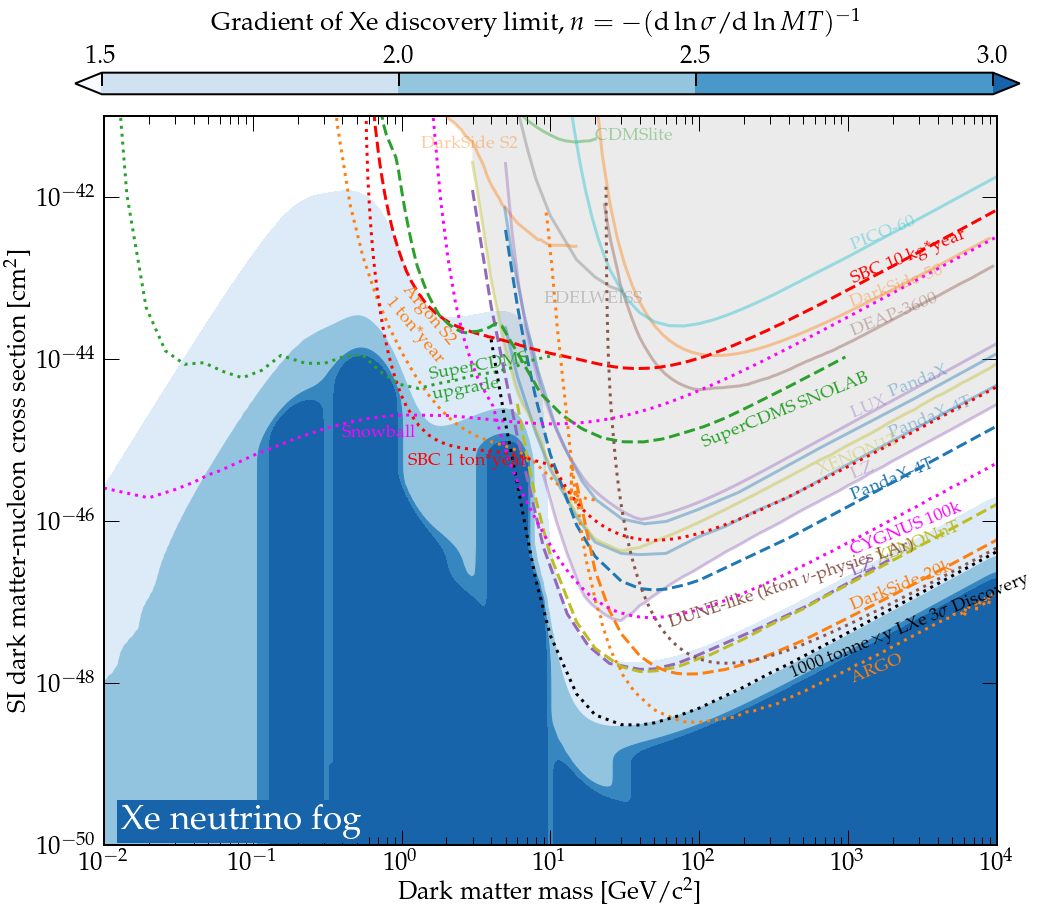

In [3]:
def plotexcludedsi(ax, details=True, **kwargs):
    data = np.loadtxt('data/published/SI/AllLimits-2021.txt')
    p4t = np.loadtxt('data/published/SI/pandax4T_2021_published.txt')
    lz = np.loadtxt('data/LZ_2022_SI.txt', usecols=(0,1))
    data = minbound([data, p4t, lz], masses=data.T[0])
    kwargs.setdefault('edgecolor', None)
    kwargs.setdefault('facecolor','#000000')
    kwargs.setdefault('alpha',0.08)
    data = extrapolate(data, 1e5)
    ax.fill_between(*(data.T), ax.get_ylim()[1], **kwargs)
    if details:
        alpha=0.4
        #ax.plotdata('data/published/SI/CRESST.txt', alpha=alpha, color='tab:pink', label={'s':'CRESST', 'x':5})
        ax.plotdata('data/published/SI/EDELWEISS.txt', alpha=alpha, color='tab:gray', label={'s':'EDELWEISS', 'x':9, 'y':5e-44})
        ax.plotdata('data/published/SI/CDMSLite.txt', alpha=alpha, color='tab:green', label={'s':'CDMSlite','x':20, 'yrel':1})
        ax.plotdata('data/published/SI/DarkSide.txt', alpha=alpha, color='tab:orange', label={'s':'DarkSide S2','x':1.35, 'y':4e-42})
        ax.plotdata('data/published/SI/DarkSide50.txt',alpha=alpha, color='tab:orange', label={'s':'DarkSide-50', 'yrel':1.15, 'rotation':20})
        ax.plotdata('data/published/SI/DEAP-3600.txt', alpha=alpha, color='tab:brown',
                    label={'s':'DEAP-3600'})
        ax.plotdata('data/published/SI/PandaX.txt', alpha=alpha, color='tab:blue',
                    label={'s':'PandaX', 'x':1800, 'y':3.5e-45})
        ax.plotdata('data/published/SI/pandax4T_2021_published.txt', alpha=alpha, color='tab:blue',
                    label={'s':'PandaX-4T', 'x':1800})
        ax.plotdata('data/published/SI/XENON1T.txt', alpha=alpha, color='tab:olive',
                    label={'s':'XENON1T', 'yrel': 0.7, 'x':600})
        ax.plotdata('data/published/SI/LUX.txt', alpha=alpha, color='tab:purple',
                    label={'s':'LUX'})
        ax.plotdata(data=lz, alpha=alpha, color='tab:purple', label={'s':'LZ'})
        ax.plotdata('data/published/SI/PICO60.txt', alpha=alpha, color='tab:cyan',
                    label={'s':'PICO-60'}, )
        #ax.plotdata('data/published/SI/COSINE-100.txt')


# Default very crowded version with everything, ARGO exclusion and Xenon discovery
        
fig, ax = makecanvas(xlim=(0.01, 10000), ylim=(1e-50, 1e-41))
plotexcludedsi(ax)
ax.plotprojection('data/LZ_projected_2019_SI.tsv', color='tab:purple', label={'s':'LZ'})
ax.plotprojection('data/XENONnT_SIproj_20ty_2020.tsv', color='tab:olive', label={'s':'XENONnT', 'x':1500})
ax.plotprojection('data/PandaX-4T_SIproj_6ty_2018.tsv', color='tab:blue', label={'s':'PandaX-4T'})
ax.plotdata('data/argon_S2only_1tyr_exclusion.tsv', color='tab:orange', linestyle='dotted', label={'s': 'Argon S2\n1 ton*year', 'x':0.75, 'y':9e-45, 'rotation':-50})
ax.plotprojection('data/ds20k_exclusion.tsv', color='tab:orange', label={'s':'DarkSide-20k'})
ax.plotprojection('data/SBC_10kg.tsv', color='red', label={'s': 'SBC 10 kg*year',})# 'x':0.8, 'y':7e-44, 'rotation':-70}, )
ax.plotdata('data/SBC_ton.tsv', color='red', linestyle='dotted', label={'s': 'SBC 1 ton*year', 'x':1.1, 'y':5e-46})
#ax.plotprojection('data/SuperCDMS_SNOLAB_Si_Combined.tsv')
#ax.plotprojection('data/SuperCDMS_SNOLAB_Ge_Combined.tsv')
ax.plotprojection('data/SuperCDMS_SNOLAB_Combined.tsv', color='tab:green', label={'s':'SuperCDMS SNOLAB', 'x':100, 'yrel':0.6, 'rotation':22})
#ax.plotdata('data/SuperCDMS_0VdetA.tsv', color='tab:green', linestyle='dotted', label={'s':'SuperCDMS potential upgrades'})
ax.plotdata('data/SuperCDMS_0VdetC.tsv', color='tab:green', linestyle='dotted', label={'s':'SuperCDMS\nupgrade','x':1.5, 'yrel':0.7,'rotation':10})
#ax.plotdata('data/Oscura30kgyearProjectionFDM1.txt', scalex=0.001, color='tab:olive', linestyle='dotted', label={'s': 'Oscura', 'x':0.15, 'rotation':20})
ax.plotdata('data/argo.tsv', linestyle='dotted', color='tab:orange',label={'s':'ARGO', 'yrel':0.7})
#ax.plotdata('data/darwin.tsv', linestyle='dotted', color='k',label={'s':'DARWIN'})
ax.plotdata('data/DUNElike.tsv', scalex=1000, linestyle='dotted', color='tab:brown',
            label={'s':r'DUNE-like (kton $\nu$-physics LAr)', 'x':60, 'y':5e-48,'rotation':18})

ax.plotdata('data/snowball_SI.txt', linestyle='dotted', color='magenta', label={'s':'Snowball','x':0.4, 'yrel':0.7})

g3_disco = np.loadtxt('data/G3_1000tonne-yrs.txt',skiprows=1,delimiter=',',dtype=float)
#ax.plotdata(None, data=g3_disco[:,(0,1)], linestyle='dotted', color='k',
#            label={'s':r'1000 tonne$\times$y LXe', 'fontsize':18, 'rotation':22,  'x': 400})
ax.plotdata(None, data=g3_disco[:,(0,2)], linestyle='dotted', color='k',
            label={'s':r'1000 tonne$\times$y LXe $3\sigma$ Discovery', 'fontsize':18, 'rotation':22, 'y':0.12e-47, 'x': 400})

ax.plotdata('data/CYGNUS100k-SI.txt', color='magenta', linestyle='dotted', label={'s':'CYGNUS 100k', 'yrel':0.7})

#plt.plot(g3_disco[:,0],g3_disco[:,1],color='k',linestyle='--',lw=3,alpha=0.99) # 90% limit
#plt.plot(g3_disco[:,0],g3_disco[:,2],color='k',linestyle='dotted',lw=3,alpha=0.99) # 3sigma disco
#ax.text(400.0,0.12e-47,r'1000 tonne$\times$y LXe $3\sigma$ Discovery',color='k',fontsize=18,rotation=22,alpha=1)

plotnufog(fig, ax, 'Xe', n_div=0.5, vmax=3, alpha=1)

#todo: add CDMS, DarkSide-50, Argo, DARWIN
#ax.plotdata('data/floors/Ar_SI.txt', color='k', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ar $n$=2 fog', 'x':30, 'yrel':1.1, 'rotation':15})
#ax.plotdata('data/floors/Si_SI_2.txt', color='k', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), filtsigma=1, label={'s':'Si $n$=2 fog', 'x':30, 'yrel':1.1, 'rotation':15})
#ax.plotdata('data/floors/Ge_SI.txt', color='g', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ge n=2 fog', 'x':50, 'rotation':15})
plt.savefig('figures/CombinedLimitPlot_SI.pdf')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


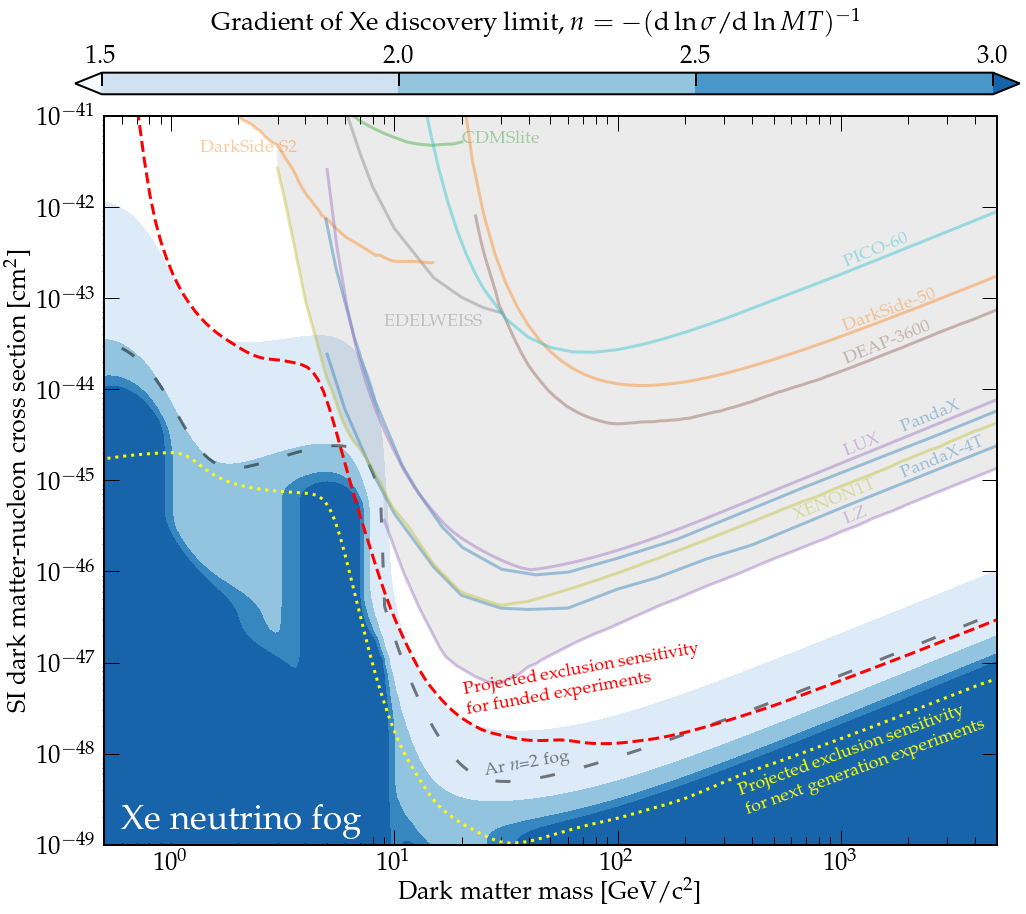

In [4]:
g3_disco = np.loadtxt('data/G3_1000tonne-yrs.txt',skiprows=1,delimiter=',',dtype=float)

def sifunded(masses=None, g2only=False):
    """ Return the combined funded sensitivity """
    
    data = [np.loadtxt(f) for f in ['data/LZ_projected_2019_SI.tsv',
                                    #'data/argon_S2only_1tyr_exclusion.tsv',
                                    'data/SuperCDMS_SNOLAB_Combined.tsv',
                                    'data/XENONnT_SIproj_20ty_2020.tsv',
                                    'data/PandaX-4T_SIproj_6ty_2018.tsv',
                                    'data/SBC_10kg.tsv',]]
    if not g2only:
        data.extend([np.loadtxt(f) for f in ['data/ds20k_exclusion.tsv',   
                                            ]])
    #damicm = np.loadtxt('data/DAMICM1kgyrprojectionFDM1.txt')
    #damicm[:,0] /= 1000
    #data.append(damicm)
    data = minbound(data, masses=masses)
    return data

def sifuture(masses=None, snowball=True):
    data = [np.loadtxt(f) for f in ['data/SuperCDMS_0VdetC.tsv',
                                    #'data/Oscura30kgyearProjectionFDM1.txt',
                                    'data/argo.tsv',
                                    'data/SBC_ton.tsv',
                                    'data/argon_S2only_1tyr_exclusion.tsv',
                                   ]]
    if snowball:
        data.append(np.loadtxt('data/snowball_SI.txt'))
    #oscura = np.loadtxt('data/Oscura30kgyearProjectionFDM1.txt')
    #oscura[:,0] /= 1000
    #data.append(oscura)
    data.append(g3_disco[:,(0,1)])
    data = minbound(data, masses=masses)
    return data

def snowmassnext(masses=None, ds=False):
    data = ['data/SuperCDMS_0VdetC.tsv',
            'data/argon_S2only_1tyr_exclusion.tsv',
            'data/XENONnT_SIproj_20ty_2020.tsv',
            'data/LZ_projected_2019_SI.tsv']
    if ds:
        data.append('data/ds20k_exclusion.tsv')
    data = [np.loadtxt(f) for f in data]
    if ds:
        data[-1][:,1] *= np.sqrt(2)
    data = minbound(data, masses=masses)
    return data


fig, ax = makecanvas(xlim=(0.5, 5000), ylim=(1e-49, 1e-41))
plotexcludedsi(ax)

ax.plotprojection(None, data=sifunded(), color='r', filtsigma=1.5,
                  label={'s':'Projected exclusion sensitivity \n for funded experiments', 'x': 20, 'yrel':1.1, 'rotation':10} )

ax.plotdata(None, data=sifuture(), color='#ffff00', filtsigma=1.5, linestyle='dotted',
                  label={'s':'Projected exclusion sensitivity \n for next generation experiments', 'x': 340, 'yrel':0.4, 'rotation':20} )

g3_disco = np.loadtxt('data/G3_1000tonne-yrs.txt',skiprows=1,delimiter=',',dtype=float)
#ax.plotdata(None, data=g3_disco[:,(0,1)], linestyle='dotted', color='k',
#            label={'s':r'1000 tonne$\times$y LXe', 'fontsize':18, 'rotation':22,  'x': 400})
#ax.plotdata(None, data=g3_disco[:,(0,2)], linestyle='dotted', color='k',
#            label={'s':r'1000 tonne$\times$y LXe $3\sigma$ Discovery', 'fontsize':18, 'rotation':22, 'y':0.12e-47, 'x': 400})




ax.plotdata('data/floors/Ar_SI.txt', color='k', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ar $n$=2 fog', 'x':25, 'yrel':1.1, 'rotation':10})
#ax.plotdata('data/floors/Ge_SI.txt', color='g', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ge n=2 fog', 'x':50, 'rotation':15})
plotnufog(fig, ax, 'Xe')
plt.savefig('figures/CombinedLimitPlot_SI_limitsonly.pdf')

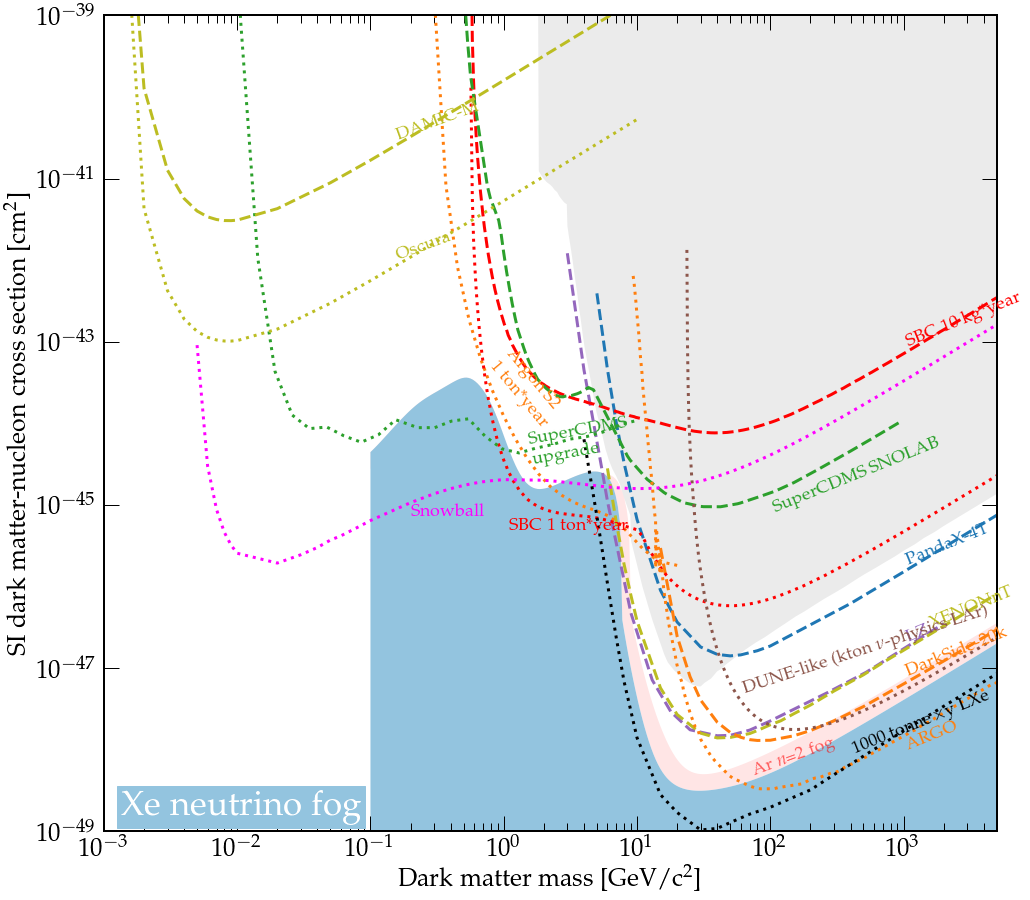

In [5]:
fig, ax = makecanvas(xlim=(0.001, 5000), ylim=(1e-49, 1e-39))
plotexcludedsi(ax, details=False)
ax.plotprojection('data/LZ_projected_2019_SI.tsv', color='tab:purple', label={'s':'LZ'})
ax.plotprojection('data/XENONnT_SIproj_20ty_2020.tsv', color='tab:olive', label={'s':'XENONnT', 'x':1500})
ax.plotprojection('data/PandaX-4T_SIproj_6ty_2018.tsv', color='tab:blue', label={'s':'PandaX-4T'})
ax.plotdata('data/argon_S2only_1tyr_exclusion.tsv', color='tab:orange', linestyle='dotted', label={'s': 'Argon S2\n1 ton*year', 'x':0.75, 'y':9e-45, 'rotation':-50})
ax.plotprojection('data/ds20k_exclusion.tsv', color='tab:orange', label={'s':'DarkSide-20k'})
ax.plotprojection('data/SBC_10kg.tsv', color='red', label={'s': 'SBC 10 kg*year',})# 'x':0.8, 'y':7e-44, 'rotation':-70}, )
ax.plotdata('data/SBC_ton.tsv', color='red', linestyle='dotted', label={'s': 'SBC 1 ton*year', 'x':1.1, 'y':5e-46})
#ax.plotprojection('data/SuperCDMS_SNOLAB_Si_Combined.tsv')
#ax.plotprojection('data/SuperCDMS_SNOLAB_Ge_Combined.tsv')
ax.plotprojection('data/SuperCDMS_SNOLAB_Combined.tsv', color='tab:green', label={'s':'SuperCDMS SNOLAB', 'x':100, 'yrel':0.6, 'rotation':22})
#ax.plotdata('data/SuperCDMS_0VdetA.tsv', color='tab:green', linestyle='dotted', label={'s':'SuperCDMS potential upgrades'})
ax.plotdata('data/SuperCDMS_0VdetC.tsv', color='tab:green', linestyle='dotted', label={'s':'SuperCDMS\nupgrade','x':1.5, 'yrel':0.7,'rotation':10})


ax.plotprojection('data/DAMICM1kgyrprojectionFDM1.txt', scalex=0.001, color='tab:olive', label={'s': 'DAMIC-M', 'x':0.15, 'rotation':20})
ax.plotdata('data/Oscura30kgyearProjectionFDM1.txt', scalex=0.001, color='tab:olive', linestyle='dotted', label={'s': 'Oscura', 'x':0.15, 'rotation':20})


ax.plotdata('data/argo.tsv', linestyle='dotted', color='tab:orange',label={'s':'ARGO', 'yrel':0.7})
#ax.plotdata('data/darwin.tsv', linestyle='dotted', color='k',label={'s':'DARWIN'})
ax.plotdata('data/DUNElike.tsv', scalex=1000, linestyle='dotted', color='tab:brown',
            label={'s':r'DUNE-like (kton $\nu$-physics LAr)', 'x':60, 'y':5e-48,'rotation':18})
ax.plotdata('data/snowball_SI.txt', linestyle='dotted', color='magenta', label={'s':'Snowball','x':0.2, 'yrel':0.7})


g3_disco = np.loadtxt('data/G3_1000tonne-yrs.txt',skiprows=1,delimiter=',',dtype=float)
ax.plotdata(None, data=g3_disco[:,(0,1)], linestyle='dotted', color='k',
            label={'s':r'1000 tonne$\times$y LXe', 'fontsize':18, 'rotation':22,  'x': 400, 'yrel':1.4})
#ax.plotdata(None, data=g3_disco[:,(0,2)], linestyle='dotted', color='k',
#            label={'s':r'1000 tonne$\times$y LXe $3\sigma$ Discovery', 'fontsize':18, 'rotation':22, 'y':0.12e-47, 'x': 400})


#plt.plot(g3_disco[:,0],g3_disco[:,1],color='k',linestyle='--',lw=3,alpha=0.99) # 90% limit
#plt.plot(g3_disco[:,0],g3_disco[:,2],color='k',linestyle='dotted',lw=3,alpha=0.99) # 3sigma disco
#ax.text(400.0,0.12e-47,r'1000 tonne$\times$y LXe $3\sigma$ Discovery',color='k',fontsize=18,rotation=22,alpha=1)


#todo: add CDMS, DarkSide-50, Argo, DARWIN
#ax.plotdata('data/floors/Ar_SI.txt', color='k', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ar $n$=2 fog', 'x':30, 'yrel':1.1, 'rotation':15})
#ax.plotdata('data/floors/Xe_SI.txt', color='b', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Xe $n$=2 fog', 'x':30, 'yrel':1.1, 'rotation':15})

xefloordata = np.loadtxt('data/floors/Xe_SI.txt')
arfloordata = np.loadtxt('data/floors/Ar_SI.txt')
ax.fill_between(*(arfloordata.T), xefloordata.T[1], #ax.get_ylim()[0], 
                edgecolor=None, facecolor='#ff0000', alpha=0.1, zorder=-50)
ax.fill_between(*(xefloordata.T), ax.get_ylim()[0], 
                edgecolor=None, facecolor='#93c4df', alpha=1, zorder=-50)
ax.text(s='Ar $n$=2 fog', x=70, y=5e-49, rotation=20, color='r', alpha=0.6, size=18)

#ax.plotdata('data/floors/Si_SI.txt', color='g', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Si n=2 fog', 'x':50, 'rotation':15})
#plotnufog(fig, ax, 'Xe')
fig.text(0.14,0.14,f'Xe neutrino fog',color='w',fontsize=35,backgroundcolor='#93c4df')
plt.savefig('figures/CombinedLimitPlot_SI_projectionsonly.pdf')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered


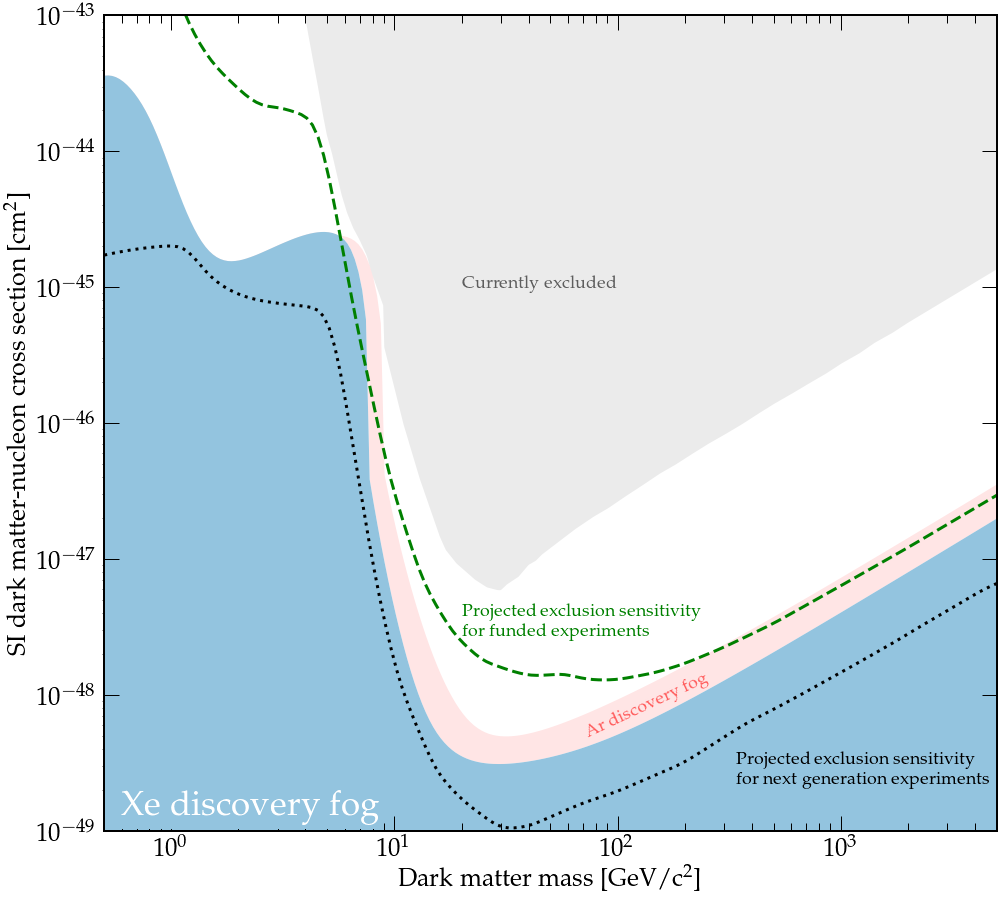

In [6]:
fig, ax = makecanvas(xlim=(0.5, 5000), ylim=(1e-49, 1e-43))
plotexcludedsi(ax, details=False)
ax.text(s='Currently excluded', x=20, y=1e-45, size=18, color='k', alpha=0.6)
ax.plotprojection(None, data=sifunded(), color='g', filtsigma=1.5,
                  label={'s':'Projected exclusion sensitivity \n for funded experiments', 'x': 20, 'yrel':1.1, 'rotation':0} )

ax.plotdata(None, data=sifuture(), color='k', filtsigma=1.5, linestyle='dotted',
                  label={'s':'Projected exclusion sensitivity \n for next generation experiments', 'x': 340, 'yrel':0.4, 'rotation':0} )

xefloordata = np.loadtxt('data/floors/Xe_SI.txt')
arfloordata = np.loadtxt('data/floors/Ar_SI.txt')
ax.fill_between(*(arfloordata.T), xefloordata.T[1], #ax.get_ylim()[0], 
                edgecolor=None, facecolor='#ff0000', alpha=0.1, zorder=-50)
ax.fill_between(*(xefloordata.T), ax.get_ylim()[0], 
                edgecolor=None, facecolor='#93c4df', alpha=1, zorder=-50)
ax.text(s='Ar discovery fog', x=70, y=5e-49, rotation=25, color='r', alpha=0.6, size=18)

#ax.plotdata('data/floors/Si_SI.txt', color='g', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Si n=2 fog', 'x':50, 'rotation':15})
#plotnufog(fig, ax, 'Xe')
fig.text(0.14,0.14,f'Xe discovery fog',color='w',fontsize=35,backgroundcolor='#93c4df')
plt.savefig('figures/CombinedLimitPlot_SI_projectionsonly.pdf')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered


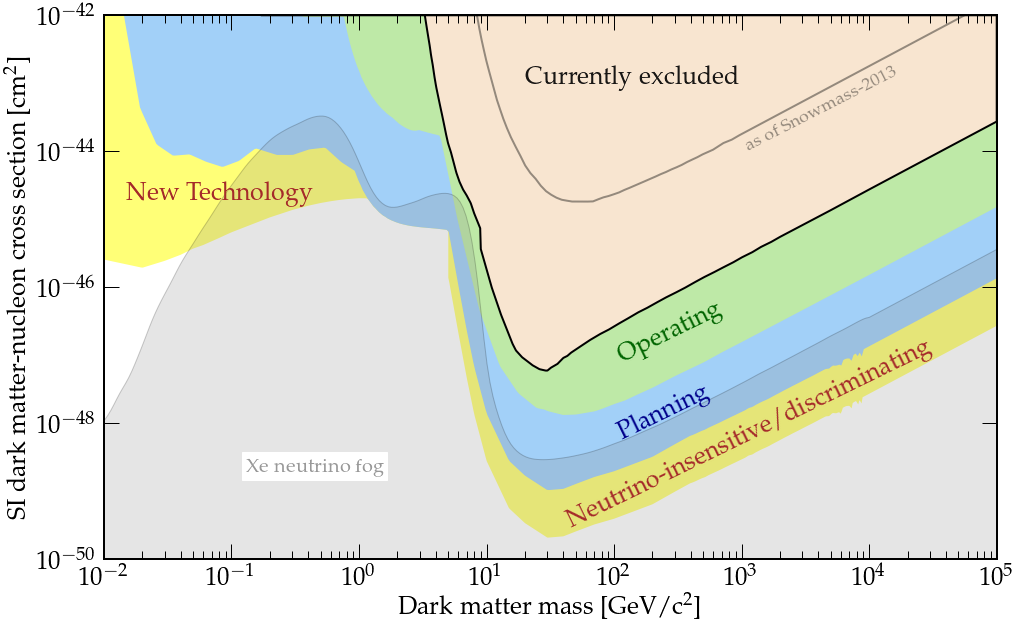

In [7]:
fig, ax = makecanvas(xlim=(0.01, 1e5), ylim=(1e-50, 1e-42), figsize=(16,10))

#ax.plotdata = partial(plotdata, ax)
#ax.plotprojection = partial(plotdata, ax, linestyle='dashed')
    
plotexcludedsi(ax, details=False, facecolor='#f8e5d0', alpha=1, edgecolor='k', linewidth=2, zorder=-1)
ax.text(s='Currently excluded', x=20, y=1e-43, size=25, color='k', alpha=0.9, fontweight='bold')
ax.plotdata('data/Snowmass2013.txt', extrapmass=1e5, color='k', alpha=0.4, linewidth=2, label={'s':'as of Snowmass-2013', 'yrel':0.6, 'rotation':27})

ax.fill_between(*(sifunded(masses=np.logspace(-3,5,500), g2only=True).T), ax.get_ylim()[1], edgecolor='#bee9a7', facecolor='#bee9a7', alpha=1, zorder=-2, linewidth=3)
ax.text(s='Operating', x=100, y=0.8e-47, size=25, color='darkgreen', alpha=1, fontweight='bold', rotation=26)

ax.fill_between(*(sifuture(masses=np.logspace(-3,5,500), snowball=False).T), ax.get_ylim()[1], edgecolor=None, facecolor='#a2d0f8', alpha=1, zorder=-3)
ax.text(s='Planning', x=100, y=6e-49, size=25, color='darkblue', alpha=1, fontweight='bold', rotation=26)
#ax.text(s='Near Term', x=0.06, y=0.2e-42, size=25, color='darkblue', alpha=1, fontweight='bold', rotation=0)

ax.fill_between(*(sifuture(masses=np.logspace(-3,4,500), snowball=True).T), ax.get_ylim()[1], edgecolor=None, facecolor='#ffff77', alpha=1, zorder=-4)
ax.text(s='New Technology', x=1.5e-2, y=2e-45, size=25, color='brown', alpha=1, fontweight='bold', rotation=0)
#ax.text(s='Search\nwide', x=0.18, y=0.2e-42, size=25, color='k', alpha=0.9, fontweight='bold', rotation=0)


lowmass = np.array([[1e-6, 1e-45], [200e-6, 1e-46]])# ,[0.1, 1e-45]])
#lowmass = minbound([lowmass, np.loadtxt('data/snowball_SI.txt')], masses=np.logspace(-6,1,200))
lowmass = np.concatenate([lowmass, np.loadtxt('data/snowball_SI.txt')[50:]], axis=0)
#ax.fill_between(*(lowmass.T), ax.get_ylim()[1], zorder=-4, edgecolor=None, facecolor='#ffff00', alpha=0.5)
#ax.fill_between(*(np.loadtxt('data/snowball_SI.txt').T), ax.get_ylim()[1], zorder=-4, edgecolor=None, facecolor='#ffff00', alpha=1)
#ax.text(s='New Technology', x=1e-5, y=3e-44, size=25, color='k', alpha=0.9, fontweight='bold', rotation=0)

beyondg3 = sifuture(masses=np.logspace(0.7,5,500))
beyondg3[:,1] /=5
ax.fill_between(*(beyondg3.T), ax.get_ylim()[1], zorder=-5, edgecolor=None, facecolor='#ffff77', alpha=1)
ax.text(s='Neutrino-insensitive/discriminating', x=40, y=3e-50, size=25, color='brown', alpha=1, fontweight='bold', rotation=26)



#ax.plotdata(data=snowmassnext(masses=np.logspace(-3,5,500), ds=True), linestyle='dashed', linewidth=2, label={'s':'as of Snowmass Next', 'yrel':1.4, 'rotation':27})


xefloor = np.loadtxt('data/floors/Xe_SI_2.txt')
xefloor[:,1] = gaussian_filter1d(xefloor[:,1], sigma=2)
xefloor = extrapolate(xefloor, 1e5)
ax.fill_between(*(xefloor.T), ax.get_ylim()[0], edgecolor='k', facecolor='gray', hatch='', alpha=0.2, linewidth=1)
foglabel = 'Neutrino 3$\sigma$ discovery fog \n for a xenon target'
foglabel = 'Xe neutrino fog'
ax.text(s=foglabel, x=0.13, y=2e-49, size=20, color='gray', alpha=0.8, backgroundcolor='w')
#ax.plotdata('data/floors/Xe_SI.txt', color='r', linewidth=2, linestyle='dashed', alpha=0.7, ) #label={'s': 'Xe discovery fog'})
#ax.plotdata('data/floors/Si_SI_2.txt', color='r', linewidth=2, linestyle='dotted', alpha=0.7, ) #label={'s': 'Xe discovery fog'})

#ax.plotdata('data/floors/Si_SI.txt', color='g', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Si n=2 fog', 'x':50, 'rotation':15})
#plotnufog(fig, ax, 'Xe', vmin=2, vmax=5, n_div=1, zorder=1)
#fig.text(0.14,0.14,f'Xe discovery fog',color='w',fontsize=35,backgroundcolor='#93c4df')

#plotnufog2(fig, ax, 'Xe', color='r', alpha=0.25, filtsigma=0)
#plt.savefig('figures/CombinedLimitPlot_SI_projectionsonly_v2.pdf')

#ax.plotdata('data/CYGNUS100k-SI.txt', linestyle='dotted', label={'s':'CYGNUS 100k', 'yrel':0.7})

def rect(x0, x1, y):
    height = 0.25
    return Rectangle((x0, y), x1-x0, height)

def plottheory(fig, ytop=1e-50, **kwargs):
    ax = fig.add_axes((0.125, 0, 0.8-0.025, 0.06))
    ax.set_xlim(1e-2, 1e5)
    ax.set_ylim(0,1)
    ax.semilogx()
    #ax.set_axis_off()
    height = 0.5
    ax.add_patch(rect(0.1, 1e4, 0))
    #ax.add_patch(Rectangle((0.1, ytop), 10, height))
    #ax.text(s='NMSSM', x=0, y=ytop/10, size=25)

#plottheory(fig)


plt.savefig('figures/CombinedLimitPlot_SI_projectionsonly_v804.pdf')

In [8]:
target='Xe'
spin='SI'
data = np.loadtxt(f'data/WIMPlimits/mylimits/DLNuFloor{target}_detailed_{spin}.txt')
Ex = np.flipud(data[1:,1:])
floor_idx = 1.5
m,sig,NUFLOOR,DY = Floor_2D(data,Ex_crit=1e19,slope_idx=floor_idx)
DY_cut = np.copy(DY)
for j in range(0,len(m)):
#for i in reversed(range(0,len(sig))):
    #print(sig[i])
#    if DY_cut[i,j] >= cut_n:
#        DY_cut[:i+1,j] = cut_n
#        break
    for i in reversed(range(0, len(sig)-1)):
        DY_cut[i,j] = max(DY_cut[i,j], DY_cut[i+1,j])
        
np.savetxt('IndexMass.txt', m)
np.savetxt('IndexSig.txt', sig)
np.savetxt('IndexValues.txt', DY)
np.savetxt('IndexValuesCut.txt',DY_cut)

print(m.shape, sig.shape, DY.shape)

(300,) (700,) (700, 300)


# Spin-dependent proton

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


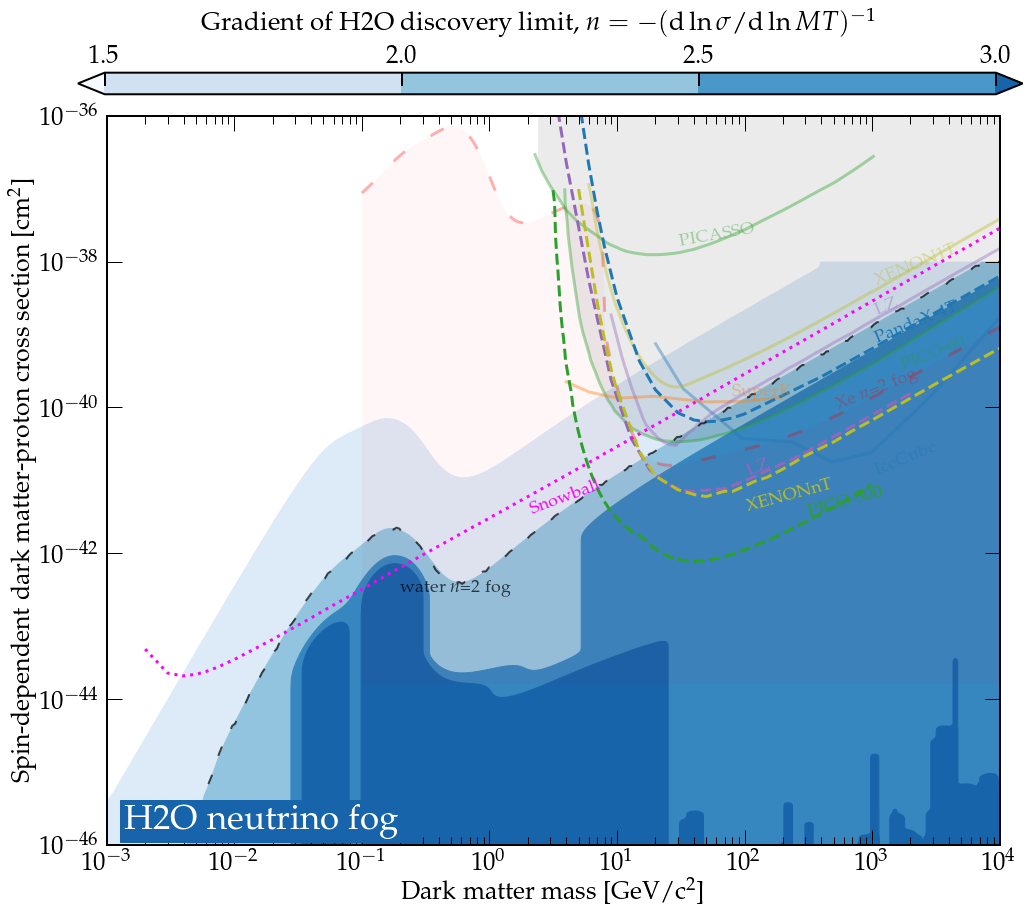

In [9]:
def plotexcludedsdp(ax):
    data = np.loadtxt('data/published/SDp/AllLimits-2021.txt')
    lz = np.loadtxt('data/LZ_2022_SDp.txt', usecols=(0,1))
    data = minbound([data,lz])
    ax.fill_between(*(data.T), ax.get_ylim()[1], edgecolor=None, facecolor='#000000', alpha=0.08)
    alpha=0.4
    ax.plotdata('data/published/SDp/PICO60.txt', alpha=alpha, color='tab:green', label={'s':'PICO-60', 'x':1600, 'yrel':0.5})
    ax.plotdata('data/published/SDp/IceCube-tt.txt', alpha=alpha, label={'s':'IceCube', 'yrel':0.5})
    #ax.plotdata('data/published/SDp/KIMS.txt', alpha=alpha, label={'s':'KIMS'})
    ax.plotdata('data/published/SDp/SuperK-tt.txt', alpha=alpha, label={'s':'SuperK','x':80,'rotation':0, 'yrel':1.2})
    ax.plotdata('data/published/SDp/XENON1T.txt', color='tab:olive', alpha=alpha, label={'s':'XENON1T'})
    ax.plotdata(data=lz, color='tab:purple', alpha=alpha, label={'s':'LZ'})
    #ax.plotdata('data/published/SDp/PICO2L.txt', alpha=alpha, label={'s':'PICO2L'})
    #ax.plotdata('data/published/SDp/COUPP.txt', alpha=alpha, label={'s':'COUPP'})
    ax.plotdata('data/published/SDp/PICASSO.txt', color='tab:green', alpha=alpha, label={'s':'PICASSO', 'x':30, 'rotation':10})

def get_contour_verts(cn):
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours


fig, ax = makecanvas(xlim=(0.001, 1e4), ylim=(1e-46,1e-36), ylabel='Spin-dependent dark matter-proton cross section [cm$^{2}$]')
plotexcludedsdp(ax)
ax.plotprojection('data/LZ_projected_2019_SDp.tsv', color='tab:purple', label={'s':'LZ', 'x':100, 'yrel':1.2})
ax.plotprojection('data/XENONnT_SD_p_proj_20ty_2020.tsv', color='tab:olive', label={'s':'XENONnT', 'x':100,'yrel':0.45,'rotation':15})
ax.plotprojection('data/PandaX-4T_SDpproj_6ty_2018.tsv', color='tab:blue', label={'s':'PandaX-4T'})
ax.plotprojection('data/PICO500_projected_LOI_SDp.tsv', color='tab:green', label={'s':'PICO-500', 'x':300, 'rotation':15})
ax.plotdata('data/snowball_SDp.txt', linestyle='dotted', color='magenta', label={'s':'Snowball','x':2, 'yrel':0.6, 'rotation':20})

cnt = plotnufog(fig, ax, 'H2O', 'SDp')

Ftop = np.fliplr(get_contour_verts(cnt)[0][0].T[:,338:1151])

ax.plotdata('data/floors/Xe_SDp.txt', color='r', alpha=0.3, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Xe $n$=2 fog', 'x':500, 'yrel':1.3})
xefloordata = np.loadtxt('data/floors/Xe_SDp.txt')
Ftopy = np.interp(xefloordata.T[0], *Ftop)

ax.fill_between(*(xefloordata.T), Ftopy, #ax.get_ylim()[0], 
                edgecolor=None, facecolor='#ff0000', alpha=0.03, zorder=-50)

ax.plotdata('data/floors/H2O_SDp_2.txt', label={'s':"water $n$=2 fog", 'x':0.2,'y':3e-43}, linestyle=(0, (5, 10)), color='k', alpha=0.7, linewidth=2)

plt.savefig('figures/CombinedLimitPlot_SDp.pdf')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered


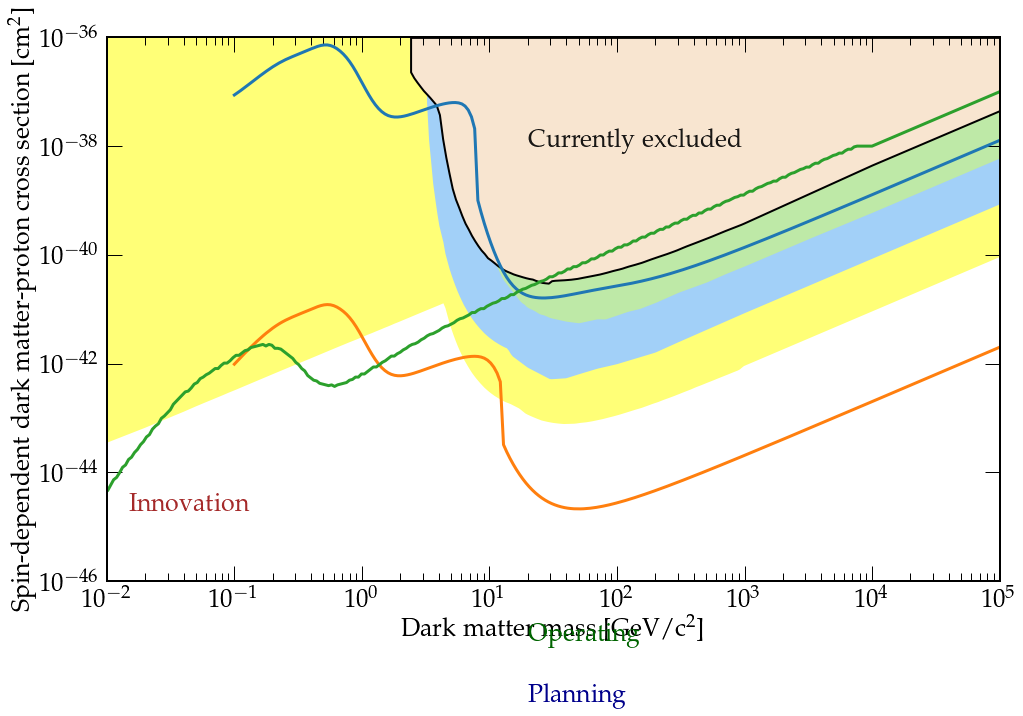

In [10]:
def plotexcludedsdp(ax, detail=True, **kwargs):
    data = np.loadtxt('data/published/SDp/AllLimits-2021.txt')
    lz = np.loadtxt('data/LZ_2022_SDp.txt', usecols=(0,1))
    data = minbound([data,lz])
    kwargs.setdefault('edgecolor', None)
    kwargs.setdefault('facecolor','#000000')
    kwargs.setdefault('alpha', 0.08)
    data = extrapolate(data, 1e5)
    ax.fill_between(*(data.T), ax.get_ylim()[1], **kwargs)
    if detail:
        alpha=0.4
        ax.plotdata('data/published/SDp/PICO60.txt', alpha=alpha, color='tab:green', label={'s':'PICO-60', 'x':1600, 'yrel':0.5})
        ax.plotdata('data/published/SDp/IceCube-tt.txt', alpha=alpha, label={'s':'IceCube', 'yrel':0.5})
        #ax.plotdata('data/published/SDp/KIMS.txt', alpha=alpha, label={'s':'KIMS'})
        ax.plotdata('data/published/SDp/SuperK-tt.txt', alpha=alpha, label={'s':'SuperK','x':80,'rotation':0, 'yrel':1.2})
        ax.plotdata('data/published/SDp/XENON1T.txt', color='tab:olive', alpha=alpha, label={'s':'XENON1T'})
        ax.plotdata(data=lz, color='tab:purple', alpha=alpha, label={'s':'LZ'})
        #ax.plotdata('data/published/SDp/PICO2L.txt', alpha=alpha, label={'s':'PICO2L'})
        #ax.plotdata('data/published/SDp/COUPP.txt', alpha=alpha, label={'s':'COUPP'})
        ax.plotdata('data/published/SDp/PICASSO.txt', color='tab:green', alpha=alpha, label={'s':'PICASSO', 'x':30, 'rotation':10})

def lxzdsdp():
    data = np.copy(g3_disco[:,(0,1)])
    data[:,1] /= 2e-7
    return data        
        
def sdpoperating(masses=np.logspace(-1,5,300)):
    data = ['data/LZ_projected_2019_SDp.tsv','data/XENONnT_SD_p_proj_20ty_2020.tsv']
    data = [np.loadtxt(f) for f in data]
    data = minbound(data, masses=masses)
    return data

def sdpplanned(masses=np.logspace(-1, 5, 300)):
    data = [np.loadtxt('data/PICO500_projected_LOI_SDp.tsv'), lxzdsdp()]
    data = minbound(data, masses=masses)
    return data

def sdpfuture(masses=np.logspace(-1,5,300), pico=True):
    data = np.loadtxt('data/snowball_SDp.txt')
    if pico:
        pdata = np.loadtxt('data/PICO500_projected_LOI_SDp.tsv')
        pdata[:,1] /= 10
        data = minbound([data, pdata], masses=masses)
    else:
        data = extrapolate(data, masses[-1])
    return data


fig, ax = makecanvas(xlim=(0.01, 1e5), ylim=(1e-46,1e-36), figsize=(16,10), ylabel='Spin-dependent dark matter-proton cross section [cm$^{2}$]')
plotexcludedsdp(ax, detail=False, facecolor='#f8e5d0', alpha=1, edgecolor='k', linewidth=2, zorder=-1)
ax.text(s='Currently excluded', x=20, y=1e-38, size=25, color='k', alpha=0.9, fontweight='bold')

ax.fill_between(*(sdpoperating(masses=np.logspace(-3,5,500)).T), ax.get_ylim()[1], edgecolor='#bee9a7', facecolor='#bee9a7', alpha=1, zorder=-2, linewidth=3)
ax.text(s='Operating', x=20, y=0.8e-47, size=25, color='darkgreen', alpha=1, fontweight='bold', rotation=0)

ax.fill_between(*(sdpplanned(masses=np.logspace(-3,5,500)).T), ax.get_ylim()[1], edgecolor=None, facecolor='#a2d0f8', alpha=1, zorder=-3)
ax.text(s='Planning', x=20, y=6e-49, size=25, color='darkblue', alpha=1, fontweight='bold', rotation=0)
#ax.text(s='Near Term', x=0.06, y=0.2e-42, size=25, color='darkblue', alpha=1, fontweight='bold', rotation=0)

ax.fill_between(*(sdpfuture(masses=np.logspace(-3,5,500)).T), ax.get_ylim()[1], edgecolor=None, facecolor='#ffff77', alpha=1, zorder=-4)
ax.text(s='Innovation', x=1.5e-2, y=2e-45, size=25, color='brown', alpha=1, fontweight='bold', rotation=0)
#ax.text(s='Search\nwide', x=0.18, y=0.2e-42, size=25, color='k', alpha=0.9, fontweight='bold', rotation=0)


#ax.plotprojection('data/LZ_projected_2019_SDp.tsv', color='tab:purple', label={'s':'LZ', 'x':100, 'yrel':1.2})
#ax.plotprojection('data/XENONnT_SD_p_proj_20ty_2020.tsv', color='tab:olive', label={'s':'XENONnT', 'x':100,'yrel':0.45,'rotation':15})
#ax.plotprojection('data/PandaX-4T_SDpproj_6ty_2018.tsv', color='tab:blue', label={'s':'PandaX-4T'})
#ax.plotprojection('data/PICO500_projected_LOI_SDp.tsv', color='tab:green', label={'s':'PICO-500', 'x':300, 'rotation':15})
#ax.plotdata('data/snowball_SDp.txt', linestyle='dotted', color='magenta', label={'s':'Snowball','x':2, 'yrel':0.6, 'rotation':20})
#ax.plotprojection(data=lxzdsdp())

ax.plotdata('data/floors/Xe_SDp.txt', extrapmass=1e5)
ax.plotdata('data/floors/F_SDp.txt', extrapmass=1e5)
ax.plotdata('data/floors/H2O_SDp_2.txt', extrapmass=1e5)



plt.savefig('figures/CombinedLimitPlot_SDp.pdf')

# Spin-dependent neutron

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


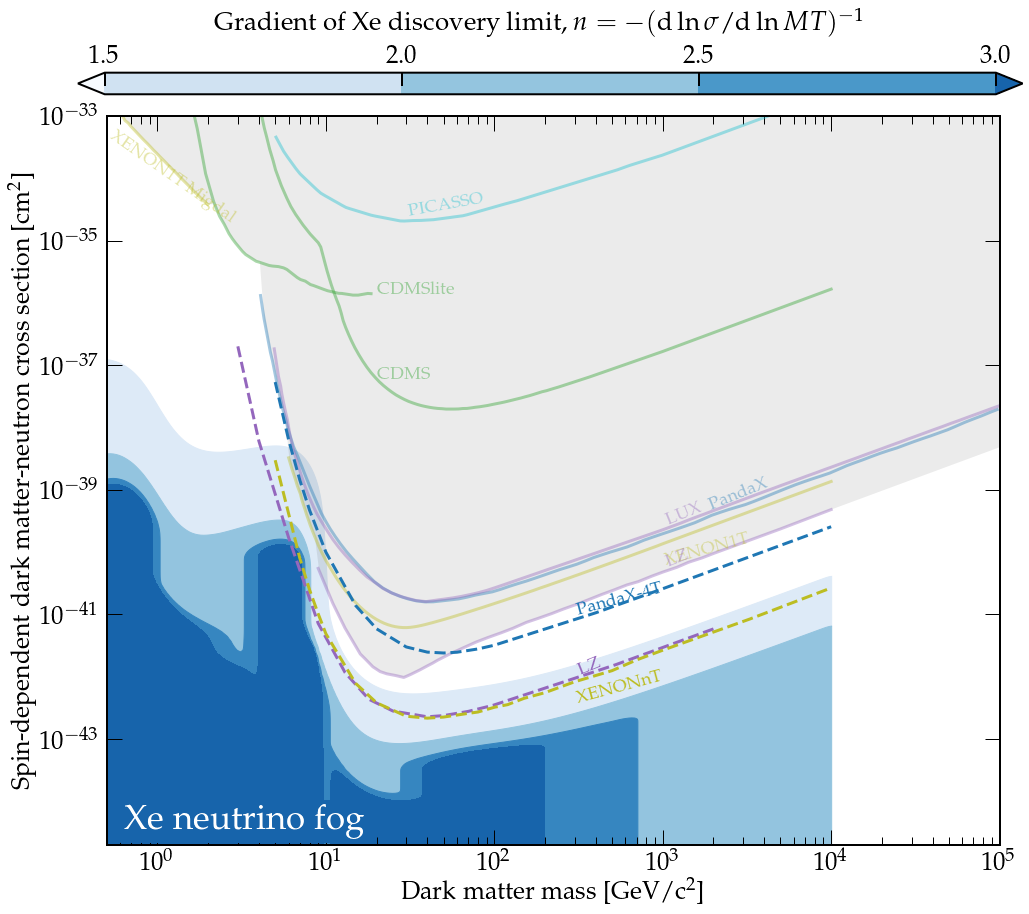

In [11]:
def plotexcludedsdn(ax, detail=True):
    data = np.loadtxt('data/published/SDn/AllLimits-migdal-2021.txt')
    lz = np.loadtxt('data/LZ_2022_SDn.txt', usecols=(0,1))
    data = minbound([data,lz])
    data = extrapolate(data, 1e5)
    ax.fill_between(*(data.T), ax.get_ylim()[1], edgecolor=None, facecolor='#000000', alpha=0.08)
    
    if detail:
        alpha=0.4
        ax.plotdata('data/published/SDn/XENON1T.txt', color='tab:olive', alpha=alpha, label={'s':'XENON1T','yrel':0.45, 'rotation':15})
        ax.plotdata('data/published/SDn/XENON1T-Migdal.txt', color='tab:olive', alpha=alpha, 
                    label={'s':'XENON1T Migdal', 'x':0.5, 'y':2e-35, 'rotation':-35})
        #ax.plotdata('data/published/SDp/PICO2L.txt', alpha=alpha, label={'s':'PICO2L'})
        #ax.plotdata('data/published/SDp/COUPP.txt', alpha=alpha, label={'s':'COUPP'})
        ax.plotdata('data/published/SDn/PICASSO.txt', color='tab:cyan', alpha=alpha, label={'s':'PICASSO', 'x':30, 'rotation':10})
        ax.plotdata('data/published/SDn/CDMSlite.txt', alpha=alpha, color='tab:green', label={'s':'CDMSlite','x':20, 'yrel':1})
        ax.plotdata('data/published/SDn/CDMS.txt', alpha=alpha, color='tab:green', label={'s':'CDMS','x':20, 'yrel':1})
        ax.plotdata('data/published/SDn/CRESST.txt', alpha=alpha, color='tab:green', label={'s':'CRESST','x':20, 'yrel':0.6})
        ax.plotdata('data/published/SDn/PandaX.txt', alpha=alpha, color='tab:blue',
                    label={'s':'PandaX','x':1800, 'yrel':1.4})
        ax.plotdata('data/published/SDn/LUX.txt', alpha=alpha, color='tab:purple',
                    label={'s':'LUX'})
        ax.plotdata(data=lz, alpha=alpha, color='tab:purple',label={'s':'LZ'})


fig, ax = makecanvas(xlim=(0.5, 1e5), ylim=(2e-45,1e-33), ylabel='Spin-dependent dark matter-neutron cross section [cm$^{2}$]')
plotexcludedsdn(ax)
ax.plotprojection('data/LZ_projected_2019_SDn.tsv', color='tab:purple', label={'s':'LZ', 'x':300, 'yrel':1.2})
ax.plotprojection('data/XENONnT_SD_n_proj_20ty_2020.tsv', color='tab:olive', label={'s':'XENONnT', 'x':300,'yrel':0.45,'rotation':15})
ax.plotprojection('data/PandaX-4T_SDnproj_6ty_2018.tsv', color='tab:blue', label={'s':'PandaX-4T', 'x':300, 'rotation':15})
plotnufog(fig, ax, 'Xe', 'SDn')


plt.savefig('figures/CombinedLimitPlot_SDn.pdf')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered


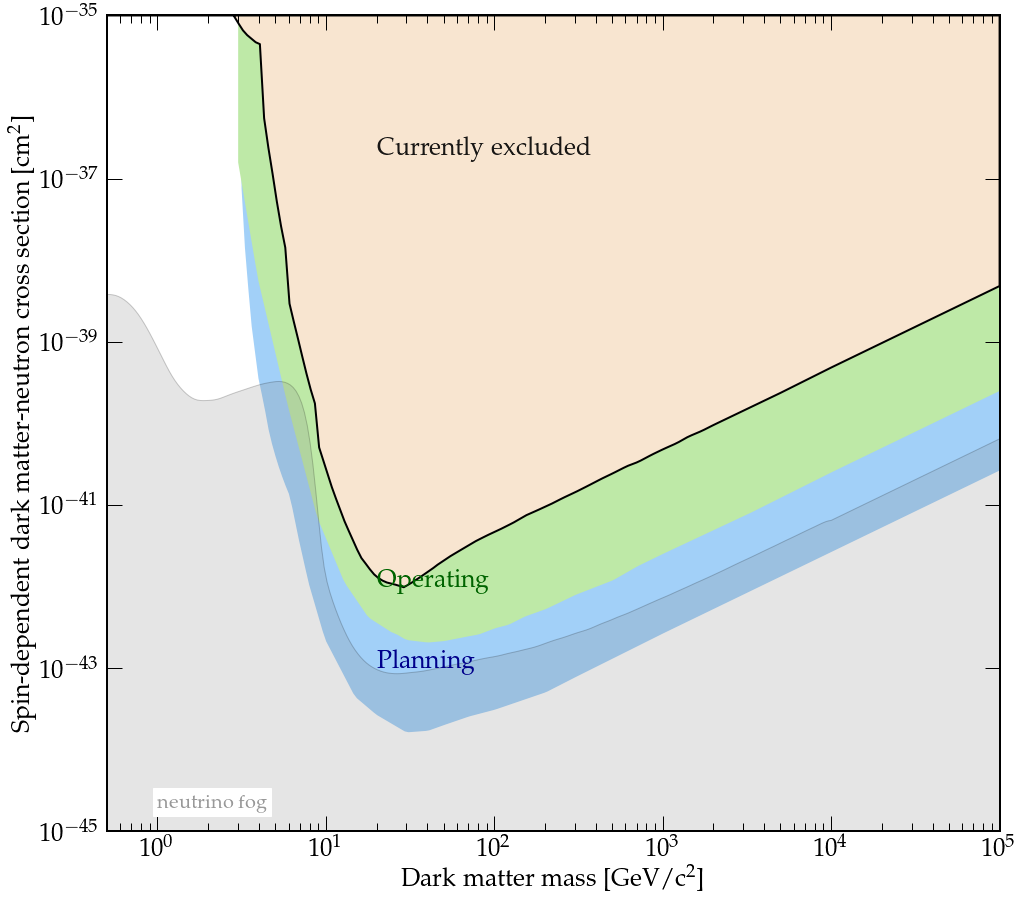

In [12]:
def lxzdsdn():
    data = np.copy(g3_disco[:,(0,1)])
    data[:,1] /= 6e-6
    return data
    

def plotexcludedsdn(ax, detail=True, **kwargs):
    data = np.loadtxt('data/published/SDn/AllLimits-migdal-2021.txt')
    lz = np.loadtxt('data/LZ_2022_SDn.txt', usecols=(0,1))
    data = minbound([data,lz])
    data = extrapolate(data, 1e5)
    kwargs.setdefault('edgecolor',None)
    kwargs.setdefault('facecolor', '#000000')
    kwargs.setdefault('alpha',0.08)
    ax.fill_between(*(data.T), ax.get_ylim()[1], **kwargs)
    
    if detail:
        alpha=0.4
        ax.plotdata('data/published/SDn/XENON1T.txt', color='tab:olive', alpha=alpha, label={'s':'XENON1T','yrel':0.45, 'rotation':15})
        #ax.plotdata('data/published/SDn/XENON1T-Migdal.txt', color='tab:olive', alpha=alpha, 
        #            label={'s':'XENON1T Migdal', 'x':0.5, 'y':2e-35, 'rotation':-35})
        #ax.plotdata('data/published/SDp/PICO2L.txt', alpha=alpha, label={'s':'PICO2L'})
        #ax.plotdata('data/published/SDp/COUPP.txt', alpha=alpha, label={'s':'COUPP'})
        ax.plotdata('data/published/SDn/PICASSO.txt', color='tab:cyan', alpha=alpha, label={'s':'PICASSO', 'x':30, 'rotation':10})
        ax.plotdata('data/published/SDn/CDMSlite.txt', alpha=alpha, color='tab:green', label={'s':'CDMSlite','x':20, 'yrel':1})
        ax.plotdata('data/published/SDn/CDMS.txt', alpha=alpha, color='tab:green', label={'s':'CDMS','x':20, 'yrel':1})
        ax.plotdata('data/published/SDn/CRESST.txt', alpha=alpha, color='tab:green', label={'s':'CRESST','x':20, 'yrel':0.6})
        ax.plotdata('data/published/SDn/PandaX.txt', alpha=alpha, color='tab:blue',
                    label={'s':'PandaX','x':1800, 'yrel':1.4})
        ax.plotdata('data/published/SDn/LUX.txt', alpha=alpha, color='tab:purple',
                    label={'s':'LUX'})
        ax.plotdata(data=lz, alpha=alpha, color='tab:purple',label={'s':'LZ'})

def sdnoperating(masses=np.logspace(-1,5,300)):
    data = ['data/LZ_projected_2019_SDn.tsv','data/XENONnT_SD_n_proj_20ty_2020.tsv']
    data = [np.loadtxt(f) for f in data]
    data = minbound(data, masses=masses)
    return data

def sdnplanned(masses=np.logspace(-1,5,300)):
    data = [np.loadtxt('data/PICO500_projected_LOI_SDp.tsv'), lxzdsdn()]
    data = minbound(data, masses=masses)
    return data

fig, ax = makecanvas(xlim=(0.5, 1e5), ylim=(1e-45,1e-35), ylabel='Spin-dependent dark matter-neutron cross section [cm$^{2}$]')
plotexcludedsdn(ax, detail=False, facecolor='#f8e5d0', alpha=1, edgecolor='k', linewidth=2, zorder=-1)
ax.text(s='Currently excluded', x=20, y=2e-37, size=25, color='k', alpha=0.9, fontweight='bold')


ax.fill_between(*(sdnoperating().T), ax.get_ylim()[1], edgecolor='#bee9a7', facecolor='#bee9a7', alpha=1, zorder=-2, linewidth=3)
ax.text(s='Operating', x=20, y=1e-42, size=25, color='darkgreen', alpha=1, fontweight='bold', rotation=0)

ax.fill_between(*(sdnplanned().T), ax.get_ylim()[1], edgecolor='face', facecolor='#a2d0f8', alpha=1, zorder=-3, linewidth=3)
ax.text(s='Planning', x=20, y=1e-43, size=25, color='darkblue', alpha=1, fontweight='bold', rotation=0)


xefloor = np.loadtxt('data/floors/Xe_SDn_2.txt')
xefloor[:,1] = gaussian_filter1d(xefloor[:,1], sigma=2)
xefloor = extrapolate(xefloor, 1e5)
ax.fill_between(*(xefloor.T), ax.get_ylim()[0], edgecolor='k', facecolor='gray', hatch='', alpha=0.2, linewidth=1)
foglabel = 'Neutrino 3$\sigma$ discovery fog \n for a xenon target'
foglabel = 'neutrino fog'
ax.text(s=foglabel, x=1, y=2e-45, size=20, color='gray', alpha=0.8, backgroundcolor='w')


plt.savefig('figures/CombinedLimitPlot_SDn.pdf')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered


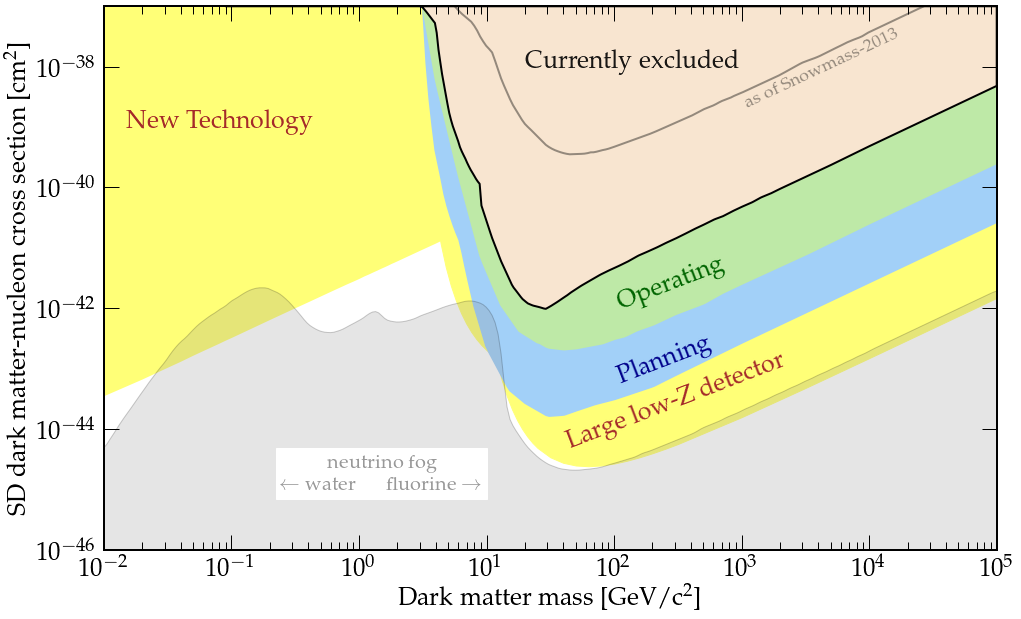

In [13]:
def sdoperating(masses=np.logspace(-2,5,300)):
    return minbound([sdpoperating(masses=masses), sdnoperating(masses=masses)], masses=masses)

def sdplanned(masses=np.logspace(-2,5,300)):
    return minbound([sdpplanned(masses=masses), sdnplanned(masses=masses)], masses=masses)

def sdfuture(masses=np.logspace(-2,5,300)):
    return sdpfuture(masses=masses, pico=False)

def sd2013(masses=np.logspace(-2, 5, 300)):
    return minbound([np.loadtxt(f) for f in ['data/Snowmass2013SDn.txt', 'data/Snowmass2013SDp.txt']], masses=masses)
    
def sdfog(masses=np.logspace(-2,5,300)):
    data = ['data/floors/H2O_SDp_2.txt', 'data/floors/F_SDp_2.txt']
    data = [np.loadtxt(f) for f in data]
    data[1] = data[1][10:]
    data = minbound(data, masses=masses)
    data[:,1] = gaussian_filter1d(data[:,1], sigma=1)
    return data

def plotexcludedsd(ax, detail=True, **kwargs):
    data = ['data/published/SDn/AllLimits-migdal-2021.txt','data/published/SDp/AllLimits-2021.txt', 
            'data/LZ_2022_SDn.txt','data/LZ_2022_SDp.txt']
    data = [np.loadtxt(f, usecols=(0,1)) for f in data]
    data = minbound(data, masses=np.logspace(-2, 5, 500))
    kwargs.setdefault('edgecolor',None)
    kwargs.setdefault('facecolor', '#000000')
    kwargs.setdefault('alpha',0.08)
    ax.fill_between(*(data.T), ax.get_ylim()[1], **kwargs)

fig, ax = makecanvas(xlim=(0.01, 1e5), ylim=(1e-46,1e-37), figsize=(16,10), ylabel='SD dark matter-nucleon cross section [cm$^{2}$]')
plotexcludedsd(ax, facecolor='#f8e5d0', alpha=1, edgecolor='k', linewidth=2, zorder=-1)
ax.text(s='Currently excluded', x=20, y=1e-38, size=25, color='k', alpha=0.9, fontweight='bold')
ax.plotdata(data=sd2013(), extrapmass=1e5, color='k', alpha=0.4, linewidth=2, label={'s':'as of Snowmass-2013', 'yrel':0.6, 'rotation':25})


ax.fill_between(*(sdoperating().T), ax.get_ylim()[1], edgecolor='#bee9a7', facecolor='#bee9a7', alpha=1, zorder=-2, linewidth=3)
ax.text(s='Operating', x=100, y=1e-42, size=25, color='darkgreen', alpha=1, fontweight='bold', rotation=21)

ax.fill_between(*(sdplanned().T), ax.get_ylim()[1], edgecolor='face', facecolor='#a2d0f8', alpha=1, zorder=-3, linewidth=3)
ax.text(s='Planning', x=100, y=6e-44, size=25, color='darkblue', alpha=1, fontweight='bold', rotation=21)

ax.fill_between(*(sdfuture(masses=np.logspace(-3,5,500)).T), ax.get_ylim()[1], edgecolor=None, facecolor='#ffff77', alpha=1, zorder=-4)
ax.text(s='New Technology', x=1.5e-2, y=1e-39, size=25, color='brown', alpha=1, fontweight='bold', rotation=0)

#pico50t = np.loadtxt('data/PICO500_projected_LOI_SDp.tsv')
#pico50t[:,1] /= 200
#pico50t[:35,1] *= 10
pico50t = np.loadtxt('data/PICOfuture_projected_LOI_SDp.tsv')
pico50t = extrapolate(pico50t, 1e5)
ax.fill_between(*(pico50t.T), ax.get_ylim()[1], edgecolor='face', facecolor='#ffff77', alpha=1, zorder=-4)
ax.text(s='Large low-Z detector', x=40, y=5e-45, size=25, color='brown', alpha=1, fontweight='bold', rotation=21)


ax.fill_between(*(sdfog().T), ax.get_ylim()[0], edgecolor='k', facecolor='gray', hatch='', alpha=0.2, linewidth=1)
#ax.plotdata('data/floors/F_SDp_2.txt')
#ax.plotdata('data/floors/H2O_SDp_2.txt')

#ax.plotdata('data/floors/Xe_SDn_2.txt', extrapmass=1e5, linestyle='dotted', color='gray', alpha=0.8)

#xefloor = np.loadtxt('data/floors/Xe_SDn_2.txt')
#xefloor[:,1] = gaussian_filter1d(xefloor[:,1], sigma=2)
#xefloor = extrapolate(xefloor, 1e5)
#ax.fill_between(*(xefloor.T), ax.get_ylim()[0], edgecolor='k', facecolor='gray', hatch='', alpha=0.2, linewidth=1)
#foglabel = 'Neutrino 3$\sigma$ discovery fog \n for a xenon target'
foglabel ='$\qquad$neutrino fog\n$\leftarrow$ water $\quad$ fluorine $\\rightarrow$'
ax.text(s=foglabel, x=1.5, y=1e-45, size=20, color='gray', alpha=0.8, backgroundcolor='w', ha='center')


#ax.plotprojection('data/CYGNUS10-SDp.txt', label={'s':'CYGNUS 10', 'yrel':0.6})
#ax.plotdata('data/CYGNUS1000-SDp.txt', linestyle='dotted', label={'s':'CYGNUS-1000', 'yrel':0.6})


plt.savefig('figures/CombinedLimitPlot_SD_projectionsonly_v804.pdf')

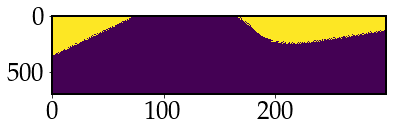

In [14]:
data = np.loadtxt('data/WIMPlimits/mylimits/DLNuFloorGe_detailed_SI.txt')
mass = data[0][1:]
sigma = data.T[0][1:][::-1]
logsigma = np.log10(sigma)
data[data == 0] = np.nan

#fig, ax = makecanvas(xlim=(0.5, 5000), ylim=(2e-45,1e-33), ylabel='Spin-dependent dark matter-neutron cross section [cm$^{2}$]')
#ax.imshow(np.log10(data[1:,1:]), aspect='auto', extent=(mass[0], mass[-1], sigma[-1], sigma[0]))

plt.figure()
plt.imshow(np.isnan(data[1:,1:]), aspect=0.1, interpolation='none')




mass = 0.014810460488806748


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: All-NaN slice encountered
  from ipykernel import kernelapp as app


(-1.0, 5.0)

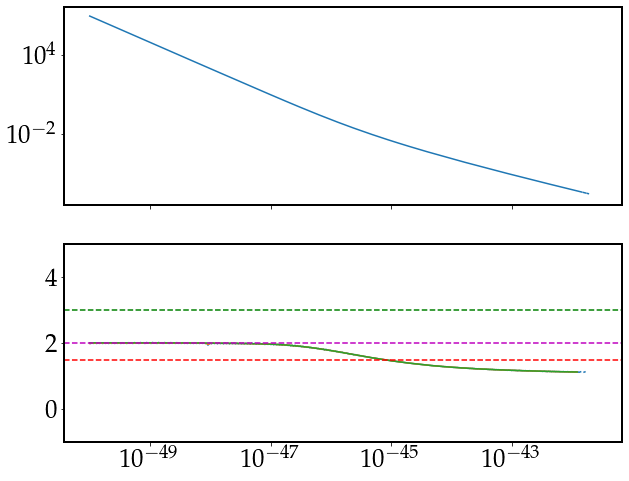

In [15]:
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)
row=50
print("mass =", mass[row])
E = data[1:,1:].T[row]
E[E==0] = np.nan #np.amin(E[E>0])
#E = gaussian_filter1d(E, sigma=1)
axs[0].plot(sigma, E)
axs[0].loglog()

index = -(np.log10(E[1:])-np.log10(E[:-1]))/(logsigma[1:]-logsigma[:-1])
index = -np.gradient(np.log10(E), logsigma[1]-logsigma[0])
smoothed = gaussian_filter1d(index, sigma=1)
maxed = np.copy(smoothed)
for i in (range(1,len(maxed))):
    maxed[i] = np.nanmax(maxed[i-1:i+1])
#print(maxed)

axs[1].plot(sigma,  index)
axs[1].plot(sigma, smoothed)
axs[1].plot(sigma, maxed)
axs[1].semilogx()
axs[1].axhline(1.5,c='r', linestyle='--')
axs[1].axhline(2,c='m', linestyle='--')
axs[1].axhline(3,c='g', linestyle='--')
axs[1].set_ylim(-1,5)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':


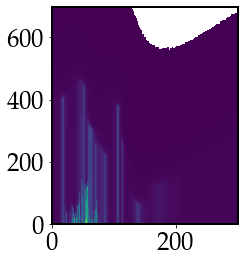

In [16]:
target='Xe'
spin='SDn'
data = np.loadtxt(f'data/WIMPlimits/mylimits/DLNuFloor{target}_detailed_{spin}.txt')
Ex = np.flipud(data[1:,1:])
floor_idx = 1.5
m,sig,NUFLOOR,DY = Floor_2D(data,Ex_crit=1e19,slope_idx=1.5, filt=False)
#DY[np.isnan(DY)] = 0
#DY[DY>3] = 3
for j in range(0,len(m)):
    for i in reversed(range(0, len(sig))): #reversed(range(0, len(sig)-1)):
        #DY_cut[i,j] = max(DY_cut[i,j], DY_cut[i+1,j])
        DY[i, j] = np.nanmax(DY[i:i+2,j])
#DY[DY>3] = 3
plt.figure()
plt.imshow(DY, aspect=0.5, origin='lower')


# Spin independent exposure to reach fog

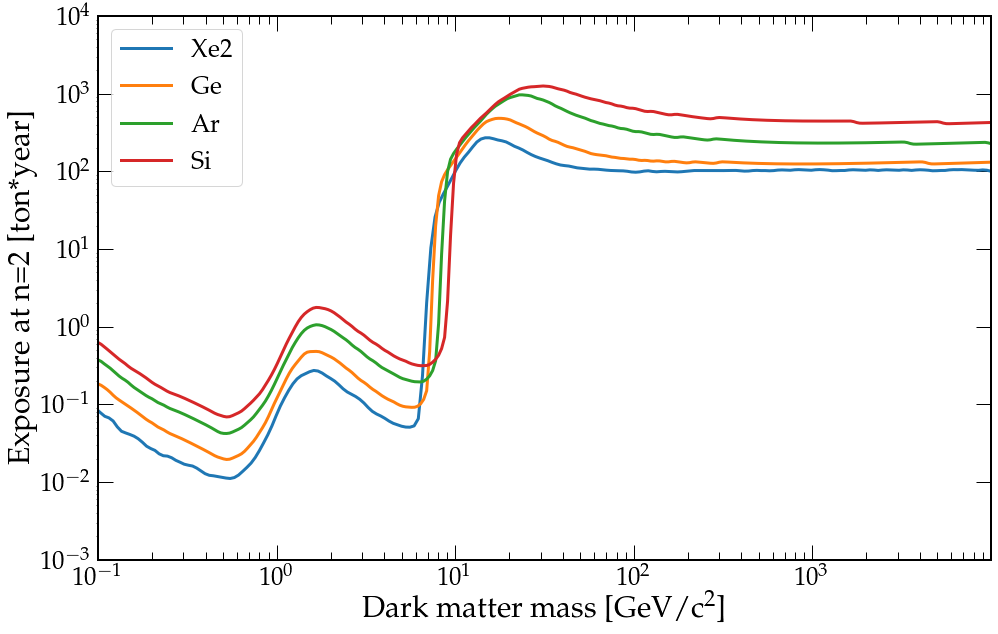

In [17]:
def makecanvas2(xlim=(1e-1, 0.999e4), ylim=(1e-3,1e4), **kwargs):
    plt.rcParams['axes.linewidth'] = kwargs.get('linewidth',2)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=kwargs.get('fontsize',25))
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'

    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,10)))
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    ax.loglog()
    kwargs.setdefault('labelfontsize',30)
    ax.set_xlabel(kwargs.get('xlabel',"Dark matter mass [GeV/c$^{2}$]"), fontsize=kwargs['labelfontsize'])
    ax.set_ylabel(kwargs.get('ylabel',"Exposure at n=2 [ton*year]"),fontsize=kwargs['labelfontsize'])


    ax.tick_params(which='major',direction='in',width=1,length=15,right=True,top=True,pad=7)
    ax.tick_params(axis='x', which='minor',direction='in',width=1,length=8,right=True,top=True)

    ax.plotdata = partial(plotdata, ax)
    ax.plotprojection = partial(plotdata, ax, linestyle='dashed')
    return fig, ax

fig, ax = makecanvas2()
ax.plotdata('data/exposure_at_floor/Xe_SI_2.txt', label='Xe2', filtsigma=1)
#ax.plotdata('data/exposure_at_floor/Xe_SI.txt', label='Xe', filtsigma=3)
ax.plotdata('data/exposure_at_floor/Ge_SI.txt', label='Ge', filtsigma=1)
ax.plotdata('data/exposure_at_floor/Ar_SI.txt', label='Ar', filtsigma=1)
#ax.plotdata('data/exposure_at_floor/F_SI.txt', label='F')
ax.plotdata('data/exposure_at_floor/Si_SI.txt', label='Si', filtsigma=1)
#ax.plotdata('data/exposure_at_floor/He_SI.txt', label='He')
ax.legend()
plt.savefig('figures/exposure_at_floor_SI.pdf')

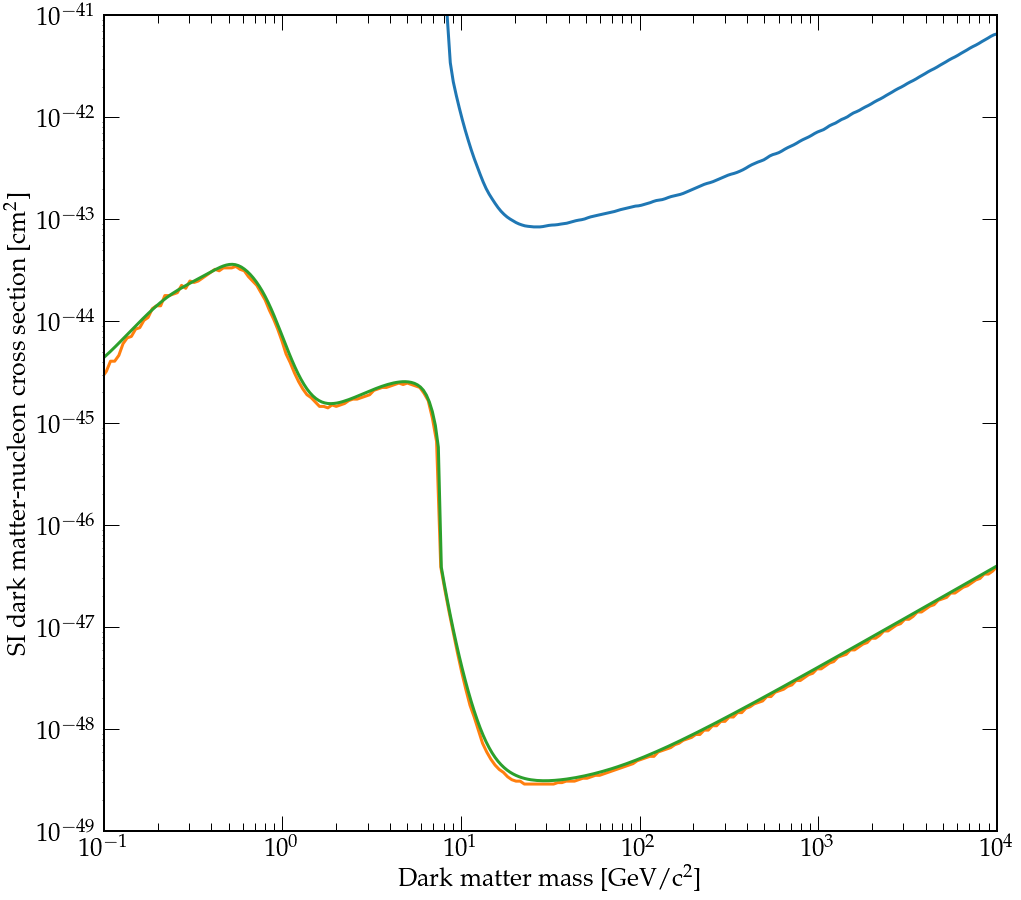

In [18]:
fig, ax = makecanvas(xlim=(0.1,1e4))
ax.plotdata('data/floors/Xe_SDn_2.txt', filtsigma=1)
ax.plotdata('data/floors/Xe_SI_2.txt')
ax.plotdata('data/floors/Xe_SI.txt')

#ax.plotdata('data/floors/Xe_SI_2.5.txt')
#ax.plotdata('data/floors/Xe_SI_3.txt', filtsigma=1)
